In [1]:
import tensorflow as tf
import numpy as np
import os.path
import random
import math
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'

path = tf.keras.utils.get_file('mnist.npz', DATA_URL)
with np.load(path) as data:
  train_examples = data['x_train']
  train_labels = data['y_train']
  test_examples = data['x_test']
  test_labels = data['y_test']
data = np.vstack((train_examples, test_examples)).reshape([70000, 784])

In [3]:
learning_rate = 1e-3
epochs        = 300
input_dim     = len(data[0])
latent_dim    = 2
layers_vae = [input_dim, int(input_dim * 2 / 3), latent_dim]

In [4]:
def glorot_init(shape):
    return tf.Variable(tf.cast(tf.random.normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.)), dtype=tf.float64))

weights_ = dict()
biases_ = dict()
for layer, layers in enumerate(zip(layers_vae, layers_vae[1:])):
    if layer == len(layers_vae) - 2:
        weights_['z_mean'] = glorot_init([layers[0], layers[1]])
        weights_['z_std']  = glorot_init([layers[0], layers[1]])
        biases_['z_mean']  = glorot_init([layers[1]])
        biases_['z_std']   = glorot_init([layers[1]])

        weights_['decoder_h1'] = glorot_init([layers[1], layers[0]])
        biases_['decoder_b1'] = glorot_init([layers[0]])
    else:
        weights_['encoder_h' + str(layer + 1)] = glorot_init([layers[0], layers[1]])
        biases_['encoder_b' + str(layer + 1)] = glorot_init([layers[1]])

        weights_['decoder_h' + str(-layer + len(layers_vae) - 1)] = glorot_init([layers[1], layers[0]])
        biases_['decoder_b' + str(-layer + len(layers_vae) - 1)] = glorot_init([layers[0]])

In [5]:
    #this function returns 1 incase the current loss is nan
    def tf_to_np(loss):
        def f0(): return tf.constant(0, tf.float64)
        def f1(): return tf.constant(1, tf.float64)
        return tf.cond(str(loss.numpy())!='nan', f0, f1)
    #this function prints the loss and the number of epoch
    def printer(loss, epoch):
        print('epoch: '+str(epoch.numpy()) + '  loss: \n' +str(loss.numpy()))
        return loss

In [6]:
#encoding
def encoding(encoder, weights, biases):
    # forward propagation for encoding layers
    for ly in range(int(len(weights) / 2) - 1):
        encoder = tf.matmul(encoder, weights['encoder_h' + str(ly + 1)]) + biases['encoder_b' + str(ly + 1)]
        encoder = tf.nn.sigmoid(encoder)
    # calculating latent probability
    z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']
    z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
    return z_mean, z_std
encoding_func = tf.function(encoding)

#decoding
def decoding(z_mean, z_std, weights, biases):
    eps = tf.random.normal(tf.shape(z_std), dtype=tf.float64, mean=0., stddev=1.0)
    decoder = z_mean + tf.exp(z_std / 2) * eps
    for ly in range(int(len(weights) / 2)):
        decoder = tf.matmul(decoder, weights['decoder_h' + str(ly + 1)]) + biases['decoder_b' + str(ly + 1)]
        if ly != int(len(weights) / 2) - 1:
            decoder = tf.nn.sigmoid(decoder)
    return decoder
decoding_func = tf.function(decoding)

#calculating result
def decoding_res(z_mean, weights, biases):
    decoder_res = z_mean
    for ly in range(int(len(weights) / 2)):
        decoder_res = tf.matmul(decoder_res, weights['decoder_h' + str(ly + 1)]) + biases['decoder_b' + str(ly + 1)]
        if ly != int(len(weights) / 2) - 1:
            decoder_res = tf.nn.sigmoid(decoder_res)
    return decoder_res
decoding_res_func = tf.function(decoding_res)

def vae_loss(x_reconstructed, x_true, z_mean, z_std):
    # Reconstruction loss - MSE
    encode_decode_loss = tf.reduce_sum(tf.abs(x_true - x_reconstructed), 1)
    #KL divergence for normal distribution
    kl_div_loss = -0.5*tf.reduce_sum(1 + z_std - tf.square(z_mean) - tf.exp(z_std), 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)
vae_loss_func = tf.function(vae_loss)

def run_opt(input_data, weights, biases, optimizer):
    with tf.GradientTape() as g:
        z_mean, z_std   = encoding_func(input_data, weights, biases)
        decoder         = decoding_func(z_mean, z_std, weights, biases)
        loss            = vae_loss_func(decoder, input_data, z_mean, z_std)
    trainable_variables = [[r for r in weights.values()] + [r for r in biases.values()]][0]
    gradients           = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss
run_opt_func = tf.function(run_opt)

In [7]:
#linear transformation of the data to [0,1]
data = (data - np.min(data)) / (np.max(data) - np.min(data))

#enter number of batches
num_of_complete_batches = 1000
if num_of_complete_batches == 0:
    num_of_complete_batches = 1
batch_size = int(len(data)/num_of_complete_batches)
residual = len(data)%batch_size

In [8]:
# going through all batches
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

for epoch in range(epochs):
    extra = 0
    for batch in range(num_of_complete_batches):
        if batch == num_of_complete_batches-1:
            extra = int(residual)
        batch_x = data[batch * batch_size:((batch + 1) * batch_size)+extra]
        ll = run_opt_func(tf.constant(batch_x,  dtype=tf.float64), weights_, biases_, optimizer)
    # # printing the loss of the last batch every 10 epoches
    if epoch % 10 == 0:
        tf.py_function(func=printer, inp=[ll, epoch], Tout=tf.float64)



epoch: 0  loss: 
103.68232406556497
epoch: 10  loss: 
92.24993586502566
epoch: 20  loss: 
86.9257283039986
epoch: 30  loss: 
83.17742615372322
epoch: 40  loss: 
81.05306541549378
epoch: 50  loss: 
79.0292565709823
epoch: 60  loss: 
77.98732915340152
epoch: 70  loss: 
77.00837652917792
epoch: 80  loss: 
75.98251960488241
epoch: 90  loss: 
75.17998911177594
epoch: 100  loss: 
75.1938167720857
epoch: 110  loss: 
74.17869434795135
epoch: 120  loss: 
73.70412663802887
epoch: 130  loss: 
73.43041465395349
epoch: 140  loss: 
73.27392246087788
epoch: 150  loss: 
72.57726307166745
epoch: 160  loss: 
72.64743982884985
epoch: 170  loss: 
71.95043148145413
epoch: 180  loss: 
72.17519864594804
epoch: 190  loss: 
72.61904593267946
epoch: 200  loss: 
72.25171962694694
epoch: 210  loss: 
71.575811772227
epoch: 220  loss: 
71.7031116279457
epoch: 230  loss: 
72.1372895418603
epoch: 240  loss: 
71.89617878487906
epoch: 250  loss: 
71.70878242998567
epoch: 260  loss: 
72.34820072450928
epoch: 270  loss: 

In [11]:
sample = tf.random.normal([100, latent_dim], mean=0.0, stddev=1.0, dtype=tf.dtypes.float64,)
generated = decoding_res_func(sample, weights_, biases_).numpy()

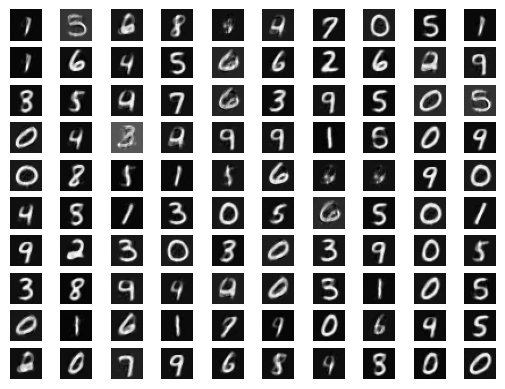

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

f, axarr = plt.subplots(10,10)
for i in range(0,10):
    for j in range(0,10):
        axarr[i,j].imshow(generated[(i*10)+j].reshape([28, 28]), cmap='gray')
        axarr[i,j].axis('off')